# A Rebecca Guay Artist Classifier

Magic: The Gathering (mtg) is a collectible card game developed by Richard Garfield that can be simply summarized as "Dungeons and Dragons with Cards". One of the great features of it is the great art that comes with it. Personally, I really enjoy art from Rebecca Guay. You can check out her spellstutter sprite below. 

This notebook builds a classifier that identifies if a particular piece of art is by Rebecca Guay. I first write a script to find the ids of the artwork by Rebecca Guay, along with the id of other magic cards using the mtg sdk. Once those ids are obtained, I get uris for all of the art done by Guay and not done by Guay using the api from [scryfall](https://scryfall.com/docs/api/cards). 

Once obtained, using the functional api of Tensorflow I detach the top of the ResNet50 convolutional neural net (CNN) trained with imagenet weights and freeze those weights. I attach a dense layer and a sigmoid layer to the CNN and use it for classification. Greater than 99% accuracy is obtained on the test set.

## Useful links
- mtg sdk: https://github.com/MagicTheGathering/mtg-sdk-python
- scryfall api for images: https://scryfall.com/docs/api/cards
- useful paper on ResNet50: http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf
- Rebecca Guay's Website: http://www.rebeccaguay.com/

(-0.5, 615.5, 451.5, -0.5)

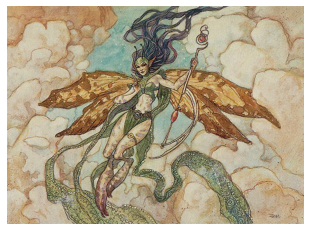

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

im = mpimg.imread("./139429.jpg")
plt.imshow(im)
plt.axis("off")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

In [3]:
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.keras.utils.vis_utils import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras import Model

In [4]:
from mtgsdk import Card
from mtgsdk import Set
from mtgsdk import Type
from mtgsdk import Supertype
from mtgsdk import Subtype
from mtgsdk import Changelog

In [5]:
import requests
import shutil
import os

In [6]:
import time
# A bunch of useful scripts for gettin art
def get_cards_for_artist(artist):
    """ Uses the mtg sdk to return all cards for which the input 
    artist is the artist 
    Args:
        artist -- the artist of the cards you want
    Returns:
        cards -- the list of cards
    """
    cards = Card.where(artist=artist).all()
    return cards

def get_image_uri(input_multiverse_id):
    """Get the uris of image (without card border) in the input_multiverse_id
    from the scryfall api
    Args:
        input_multiverse_id -- id for mtg card to get url for
    Returns:
        image_url -- list of image url
    """
    
    api_link = "https://api.scryfall.com/cards/multiverse/{}".format(input_multiverse_id)
    response = requests.get(api_link)
    if response.status_code==200:
        response_json = response.json()
        try:
            image_uri = response_json["image_uris"]["art_crop"]
        except:
            return None
        time.sleep(.1) #API requests to wait 50-100 ms per request
        return image_uri
    else:
        return None


def download_images(cards, folder_dir):
    """ Download all images of the list of cards to the folder dir
    Args:
        image_urls -- list of cards' images to download
        folder_dir -- relative folder directory to save them in
    """
    
    for card in cards:
        filename = folder_dir+"{}".format(card.multiverse_id)
        filename = filename+'.jpg'
        # Only download if the file doesn't exist or exists and is of zero size for some reason
        if (os.path.exists(filename)==False) or (os.path.exists(filename)==True and os.path.getsize(filename)<10):
            image_uri = get_image_uri(card.multiverse_id)
            
            if image_uri is not None:
                response = requests.get(image_uri, stream = True)
                time.sleep(.1) #API requests to wait 50-100 ms per request
            
                # download the image if the status code is fine
                if response.status_code==200:
                    response.raw.decode_content=True            
                    try:
                        with open(filename, 'wb') as f:
                            shutil.copyfileobj(response.raw, f)
                    except:
                        pass
   

In [8]:
# Download Rebecca Guay Card Images
card_list_guay = get_cards_for_artist('Rebecca Guay')
download_images(card_list_guay, 'img/guay/')

In [ ]:
# Download all M21, M19, and M10 cards to train.
cards_not_guay = Card.where(set='m20').all()
cards_not_guay = cards_not_guay + Card.where(set='m21').all()
cards_not_guay = cards_not_guay + Card.where(set='m19').all()
cards_not_guay = cards_not_guay + Card.where(set='m10').all()

In [ ]:
cards_not_guay = [card for card in cards_not_guay if card.artist!="Rebecca Guay"]

In [10]:
download_images(cards_not_guay, 'img/not_guay/')

In [10]:
BATCH_SIZE = 16
IMG_SIZE = (452, 616)
IMG_SHAPE = IMG_SIZE + (3,)
img_dir = "img/"

In [11]:
train_dataset = tf.keras.utils.image_dataset_from_directory(img_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                           )
class_names = train_dataset.class_names

Found 1547 files belonging to 2 classes.


In [12]:
# # Take 20 percent of the training data for testing, then will remove
num_batches = tf.data.experimental.cardinality(train_dataset)
test_dataset = train_dataset.take(num_batches//5)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

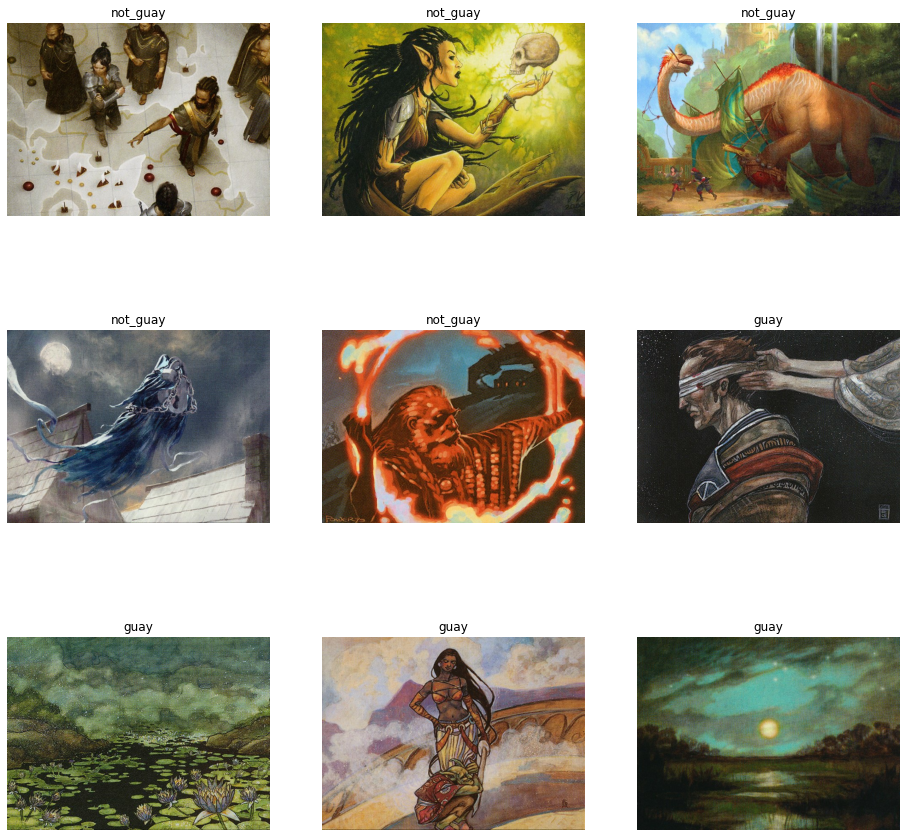

In [123]:
plt.figure(figsize=(16, 16))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
def create_model(in_dense):
    #Create the base model
    base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable=False
    
    #Create data augmenter

    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal'),
      tf.keras.layers.RandomRotation(0.2),
    ])
    
    #Get the output we want to capture
    last_layer = base_model.get_layer('conv5_block3_out')
    last_output = last_layer.output
    
    #Use the preprocessor
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
    
    #define the model
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(in_dense, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return Model(base_model.inputs, x) #start model at base_model inputs so we don't have to preprocess every time

DENSE = 32
model = create_model(DENSE)

In [15]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
NUM_EPOCHS = 5
history = model.fit(train_dataset, epochs = NUM_EPOCHS)

Epoch 1/5
88/97 [==========================>...] - ETA: 36s - loss: 9.5790 - accuracy: 0.9332

In [87]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy().T
predictions = np.array([i for i in predictions[0]])
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

Predictions:
 [1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1]
Labels:
 [1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1]


In [88]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

19/19 [==============================] - 8s 373ms/step - loss: 0.0102 - accuracy: 0.9967
Test accuracy : 0.9967105388641357


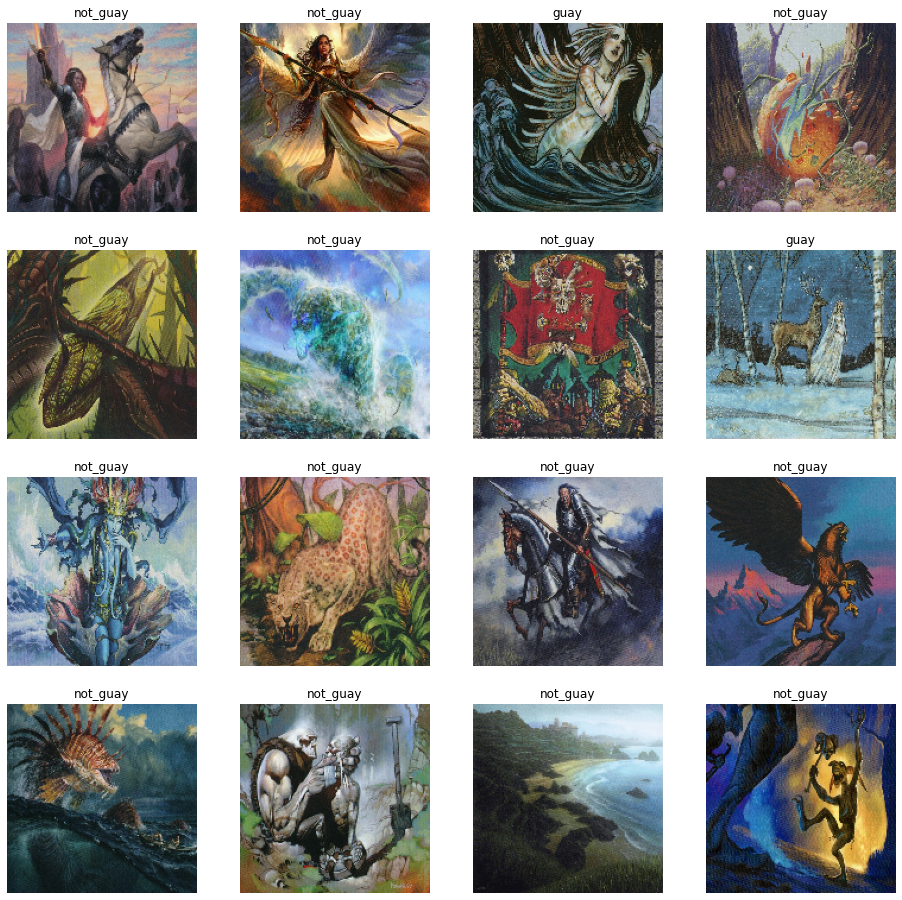

In [89]:
plt.figure(figsize=(16, 16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [125]:
model.save('guay_classifier.h5')

/home/jcummings/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
